# Machine Learning Project

## Table of Contents
- [Import Data](#import-data)
  - [Import Data Summary](#import-data-summary)
- [Data Exploration](#data-exploration)
  - [Boolean Features](#boolean-features)
    - [Boolean Features Analysis](#boolean-features-analysis)
  - [Categorical Features](#categorical-features)
    - [Check Categorical Features Consistency](#check-categorical-features-consistency)
    - [Categorical Features Summary](#categorical-features-summary)
  - [Numerical Features](#numerical-features)
    - [Numerical Plots](#plots)
    - [Analysis of Numerical Distributions](#analysis-of-numerical-distributions)
- [Pre-processing](#pre-processing)
  - [Summary of Preprocessing Pipeline](#preprocessing-pipeline-summary)
  - [Data Preparation](#data-preparation)
    - [Correlation Analysis](#correlation-analysis)
- [Model Training](#model-training)
  - [Model Selection with Cross-Validation](#model-selection-with-cv)
  - [Quick Baseline Model](#quick-baseline-model)
  - [Experiment Algorithms](#experiment-algorithms)
- [Predictions](#predictions)

# Abstract

### Context:
This project addresses car price prediction—a fundamental regression task in machine learning. The dataset includes features spanning categorical attributes (brand, model, transmission type, fuel type) and numerical characteristics (mileage, engine size, tax, MPG, paint quality). This problem is relevant for automotive valuations, insurance pricing, and market analysis.

### Objectives:
The primary goals were to:
1.  Systematically explore and preprocess complex, real-world automotive data containing missing values, outliers, and inconsistencies.
2.  Develop a robust preprocessing pipeline that prevents data leakage through proper fold-wise application.
3.  Benchmark multiple regression algorithms with hyperparameter tuning via cross-validation.
4.  Identify the most influential features through importance analysis.

### Methodology:
Data exploration revealed categorical inconsistencies (typos, spacing variations) and numerical anomalies (negative values, out-of-range percentages). The preprocessing pipeline incorporated:
* General cleaning
* Categorical standardization using edit distance
* Outlier handling via IQR method
* Imputation with training-set medians
* One-hot encoding
* Feature normalization


### Main Results:
**Ridge regression** with log-transformed targets established a baseline (MAE on validation). Feature importance revealed that `mileage`, `year`, and `engine size` are primary predictors, while `hasDamage` and certain categorical overflow categories contributed minimal signal. The hyperparameter tuning identified optimal configurations for each algorithm, with **ensemble methods** generally outperforming linear approaches. Cross-validation metrics tracked both training and validation performance to detect overfitting.

### Conclusions:
The project demonstrates that systematic preprocessing and ensemble approaches significantly improve prediction accuracy. Feature engineering and selection based on importance analysis reduced model complexity while preserving predictive power, supporting the principle that data quality and feature selection are as critical as algorithm choice in regression tasks.

<a id="import-data"></a>
## Import Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import loguniform, randint
from model_training_utils import (
    general_cleaning,
    preprocess_data,
    cross_validate_with_tuning,
    preprocess_test_data,
    get_feature_importance
)

SEED = 42

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/train.csv').set_index('carID')
df.head()

,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,,
69512,VW,Golf,2016.0,22290,Semi-Auto,28421.0,Petrol,NaN,11.417268,2.0,63.0,4.000000,0.0
53000,Toyota,Yaris,2019.0,13790,Manual,4589.0,Petrol,145.0,47.900000,1.5,50.0,1.000000,0.0
6366,Audi,Q2,2019.0,24990,Semi-Auto,3624.0,Petrol,145.0,40.900000,1.5,56.0,4.000000,0.0
29021,Ford,FIESTA,2018.0,12500,anual,9102.0,Petrol,145.0,65.700000,1.0,50.0,-2.340306,0.0
10062,BMW,2 Series,2019.0,22995,Manual,1000.0,Petrol,145.0,42.800000,1.5,97.0,3.000000,0.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 75973 entries, 69512 to 15795
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Brand           74452 non-null  object 
 1   model           74456 non-null  object 
 2   year            74482 non-null  float64
 3   price           75973 non-null  int64  
 4   transmission    74451 non-null  object 
 5   mileage         74510 non-null  float64
 6   fuelType        74462 non-null  object 
 7   tax             68069 non-null  float64
 8   mpg             68047 non-null  float64
 9   engineSize      74457 non-null  float64
 10  paintQuality%   74449 non-null  float64
 11  previousOwners  74423 non-null  float64
 12  hasDamage       74425 non-null  float64
dtypes: float64(8), int64(1), object(4)
memory usage: 8.1+ MB


In [4]:
num_duplicated_ids = df.index.duplicated().sum()
print(f'Number of duplicated carIDs: {num_duplicated_ids}')

Number of duplicated carIDs: 0


<a id="import-data-summary"></a>
#### Import Data Summary
- Dataset loaded successfully with `carID` as the index
- There are no duplicate entries in carID
- The dataset contains information about cars including both numerical features (price, mileage, tax, etc.) and categorical features (brand, model, transmission, etc.)
- Initial inspection shows multiple features that will require preprocessing:
  - Numerical features that need cleaning (negative values, outliers)
  - Categorical features that need standardization
  - Presence of missing values in several columns

<a id="data-exploration"></a>
## Data Exploration

<a id="boolean-features"></a>
### Boolean Features

In [5]:
df['hasDamage'].value_counts(dropna=False)

hasDamage
0.0    74425
NaN     1548
Name: count, dtype: int64

<a id="boolean-features-analysis"></a>
#### Boolean Features Analysis

Key observations about `hasDamage` feature:
- Only contains binary values (0) and NaN
- No instances of value 1 found, suggesting potential data collection issues
- May indicate:
  - Cars with damage not being listed
  - System default setting of 0 for non-damaged cars
  - Incomplete damage assessment process
- Requires special handling in preprocessing:
  - Consider treating NaN as a separate category
  - Validate if 0 truly represents "no damage"
  - May need to be treated as a categorical rather than boolean feature

<a id="categorical-features"></a>
### Categorical Features

<a id="check-categorical-features-consistency"></a>
#### Check Categorical Features Consistency

In [6]:
# List of categorical features
cat_cols = ['Brand', 'model', 'fuelType', 'transmission']

# Identify outlier examples in categorical features
cat_outliers_examples = {col: df[col].value_counts().tail(10).index for col in cat_cols}

# Display the outlier examples
pd.DataFrame(cat_outliers_examples)

,Brand,model,fuelType,transmission
0,mercede,m3,Othe,utomati
1,kod,GOLF SV,ther,manual
2,AUD,Avensis,Electric,AUTOMATI
3,KODA,s-ma,YBRID,emi-Aut
4,HYUNDA,X4,OTHER,Other
5,OYOTA,m4,other,semi-aut
6,SKOD,yaris,HYBRI,manua
7,TOYOT,FOCUS,ybri,UTOMATIC
8,skod,arteon,ETRO,manual
9,toyot,glb class,IESE,nknow


<a id="categorical-features-summary"></a>
#### Categorical Features Summary
- Initial analysis reveals significant data quality issues across all categorical columns
- No standardization in categorical features, with multiple variations of the same values (different spellings, capitalizations)
- Solution: We will implement string distance-based standardization using the `nltk` library to clean and standardize these features

<a id="numerical-features"></a>
### Numerical Features

In [7]:
# Dict of numerical features
num_cols = {
    'price': 'continuous',
    'mileage': 'continuous',
    'tax': 'continuous',
    'mpg': 'continuous',
    'paintQuality%': 'continuous',
    'engineSize': 'continuous',
    'year': 'discrete',
    'previousOwners': 'discrete'
}

<a id="plots"></a>
#### Numerical Plots

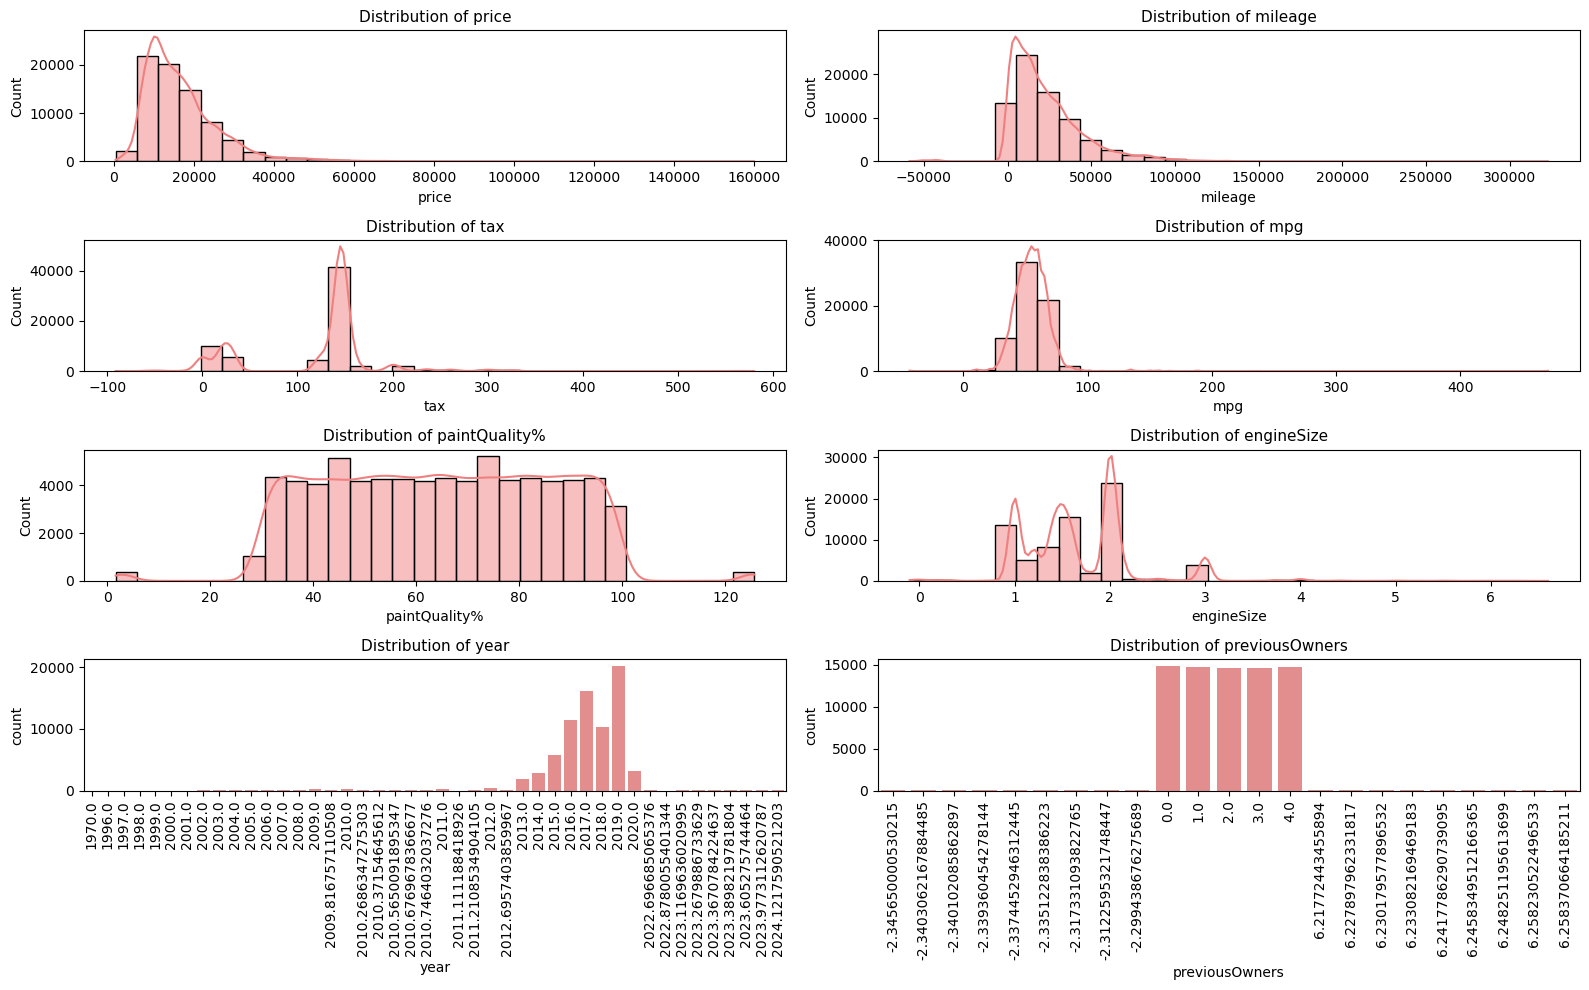

In [8]:
# Plot figures for numerical features and the target variable (price)
plt.figure(figsize=(16, 10))
for i, (col, var_type) in enumerate(num_cols.items(), 1):
    plt.subplot(4, 2, i)

    # Plot based on variable type
    if var_type == 'continuous':
        sns.histplot(data=df, x=col, kde=True, color="lightcoral", bins=30)
        plt.title(f"Distribution of {col}", fontsize=11)
    elif var_type == 'discrete':
        sns.countplot(data=df, x=col, color="lightcoral")
        plt.title(f"Distribution of {col}", fontsize=11)
        plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

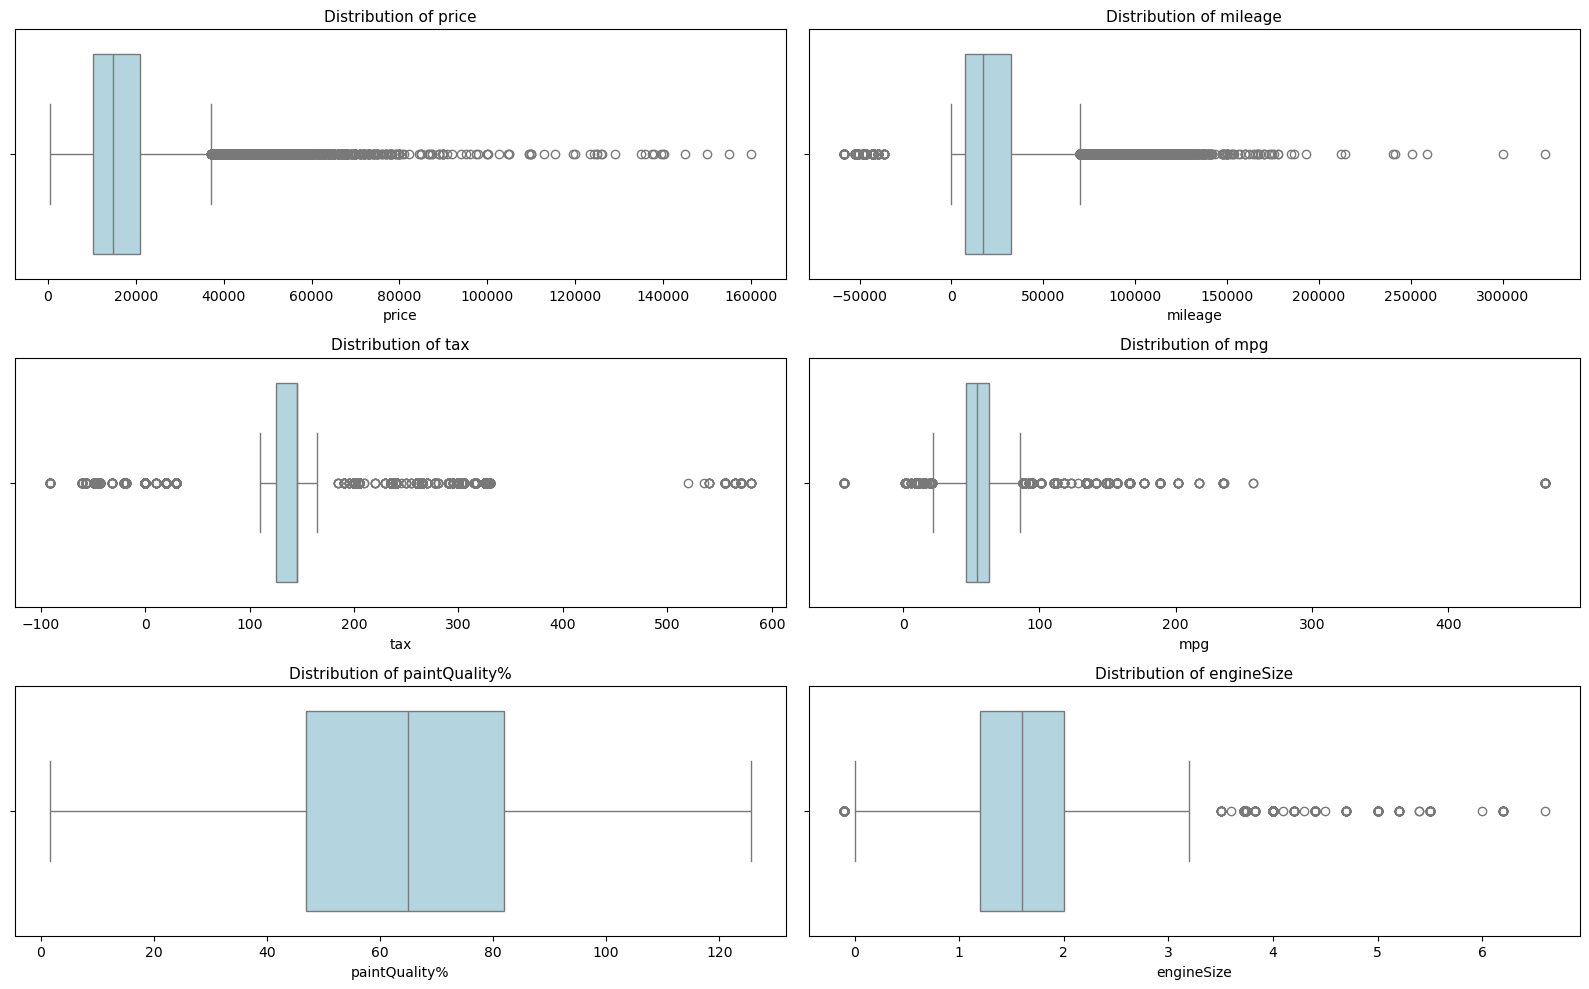

In [9]:
# Boxplots for continuous numerical features and the target variable (price)
continuous_cols = [col for col, var_type in num_cols.items() if var_type == 'continuous']
plt.figure(figsize=(16, 10))
for i, col in enumerate(continuous_cols, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(data=df, x=col, color="lightblue")
    plt.title(f"Distribution of {col}", fontsize=11)

plt.tight_layout()
plt.show()

<a id="analysis-of-numerical-distributions"></a>
#### Analysis of Numerical Distributions

Key observations from the plots:
- **Target Variable (Price)**:
  - Highly right-skewed distribution
  - Contains significant number of outliers in the upper range
  - Most cars are concentrated in the lower price range

- **Mileage**:
  - Right-skewed distribution
  - Large range from nearly new cars to high-mileage vehicles
  - Some outliers in upper range suggesting possible data entry errors

- **Tax**:
  - Multiple peaks suggesting different tax bands
  - Contains negative values which require investigation (possible tax benefits/rebates)
  - Large number of outliers on both ends of the distribution

- **MPG (Miles Per Gallon)**:
  - Approximately normal distribution with slight right skew
  - Some unrealistic extreme values that need cleaning
  - Reasonable median around typical car efficiency ranges

- **Paint Quality %**:
  - Contains values above 100% which are logically impossible
  - Left-skewed distribution suggesting optimistic ratings
  - Requires standardization to 0-100 range

- **Engine Size**:
  - There are engine size with zero values which are not realistic (might indicate electric vehicles)
  - Some unusual patterns that need investigation
  - Contains outliers that may represent specialty vehicles

- **Year**:
  - Should be discrete but contains decimal values

- **Previous Owners**:
  - Should be integer but contains float values
  - Right-skewed distribution as expected
  - Maximum values need validation (unusually high number of previous owners)

<a id="pre-processing"></a>
## Pre-processing

<a id="preprocessing-pipeline-summary"></a>
## Summary of Preprocessing Pipeline

The preprocessing is now properly separated:

1. **`preprocess_data()`** - Preprocesses a single dataset
   - Handles categorical features (standardization, encoding)
   - Handles numerical outliers using IQR method
   - Imputes missing values with medians
   - One-hot encodes categorical features
   - Normalizes numerical features with StandardScaler
   - Can fit transformers (fit=True) or use existing ones (fit=False)

2. **`cross_validate_with_tuning()`** - Performs CV with hyperparameter tuning
   - Takes **raw data** (after general_cleaning)
   - Applies preprocessing **separately for each fold** (prevents data leakage)
   - Performs manual hyperparameter search by sampling from parameter distributions
   - Evaluates each combination on validation fold and tracks train/validation performance
   - Returns best model configurations

3. **`preprocess_test_data()`** - Preprocesses test data
   - Uses artifacts from CV to ensure consistency

<a id="data-preparation"></a>
### Data Preparation

In [10]:
# Prepare cleaned data for cross-validation
df_cleaned = general_cleaning(df)
X = df_cleaned.drop(columns=["price"])
y = df_cleaned["price"]

# Remove 'price' from num_cols since it's the target
del num_cols['price']

print(f"Dataset size: {X.shape}")
print(f"Target range: £{y.min():.2f} - £{y.max():.2f}")


Dataset size: (75973, 12)
Target range: £450.00 - £159999.00


<a id="correlation-analysis"></a>
#### Correlation Analysis

Before model training, let's examine correlations between numerical features to understand their relationships.

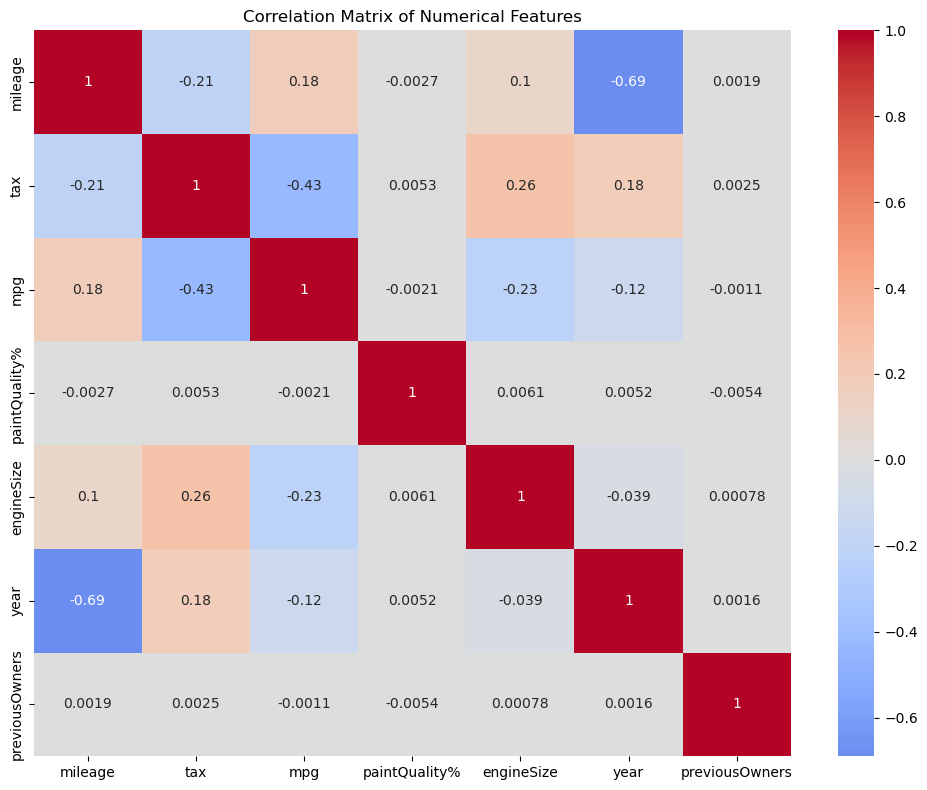

In [11]:
# Correlation matrix for numerical features
fig = plt.figure(figsize=(10, 8))
corr = X[list(num_cols.keys())].corr(method="pearson")
sns.heatmap(data=corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

<a id="model-training"></a>
## Model Training

<a id="model-selection-with-cv"></a>
### Model Selection with Cross-Validation

We'll use cross-validation with hyperparameter tuning to select the best model. Configure your model using a dictionary with the model class, parameter distributions, and number of iterations.

<a id="quick-baseline-model"></a>
### Quick Baseline Model

Before running extensive CV, let's train a simple baseline model for quick reference.

In [12]:
# Quick train/val split for baseline
X_train_baseline, X_val_baseline, y_train_baseline, y_val_baseline = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

# Preprocess baseline data
X_train_processed, baseline_artifacts = preprocess_data(X_train_baseline, cat_cols, num_cols, fit=True)
X_val_processed = preprocess_data(X_val_baseline, cat_cols, num_cols, artifacts=baseline_artifacts, fit=False)

# Train simple Ridge model
baseline_model = Ridge(alpha=1.0, fit_intercept=True)
baseline_model.fit(X_train_processed, np.log1p(y_train_baseline))

# Evaluate
y_train_pred = np.expm1(baseline_model.predict(X_train_processed))
y_val_pred = np.expm1(baseline_model.predict(X_val_processed))

mae_train = mean_absolute_error(y_train_baseline, y_train_pred)
mae_val = mean_absolute_error(y_val_baseline, y_val_pred)
r2_val = r2_score(y_val_baseline, y_val_pred)

print(f"Baseline Ridge (alpha=1.0):")
print(f"  Train MAE: £{mae_train:.2f}")
print(f"  Val MAE:   £{mae_val:.2f}")
print(f"  Val R²:    {r2_val:.4f}")
print(f"\nThis gives us a reference point before hyperparameter tuning with CV.")

Baseline Ridge (alpha=1.0):
  Train MAE: £2565.88
  Val MAE:   £2519.93
  Val R²:    0.7911

This gives us a reference point before hyperparameter tuning with CV.


<a id="feature-importance-analysis"></a>
### Feature Importance Analysis

In this section, we will train 4 different models (Ridge, Random Forest, Gradient Boosting, and Extra Trees) to analyze feature importance. Based on the results, we will select a subset of features to use for the final hyperparameter tuning.

In [13]:
# Models for Feature Importance Analysis
# We use default parameters or a small search space for quick analysis

# 1. Ridge (Linear)
print("--- Ridge Feature Importance ---")
fi_ridge_config = {
    'model_class': Ridge, 
    'param_distributions': {'alpha': [1.0]}, 
    'n_iter': 1
}
fi_ridge_results = cross_validate_with_tuning(
    X, y, cat_cols, num_cols, fi_ridge_config, k=3, seed=SEED, verbose=False
)

# 2. Random Forest
print("\n--- Random Forest Feature Importance ---")
fi_rf_config = {
    'model_class': RandomForestRegressor, 
    'param_distributions': {'n_estimators': [100], 'max_depth': [10]}, 
    'n_iter': 1
}
fi_rf_results = cross_validate_with_tuning(
    X, y, cat_cols, num_cols, fi_rf_config, k=3, seed=SEED, verbose=False
)

# 3. Gradient Boosting
print("\n--- Gradient Boosting Feature Importance ---")
fi_gb_config = {
    'model_class': GradientBoostingRegressor, 
    'param_distributions': {'n_estimators': [100], 'max_depth': [5]}, 
    'n_iter': 1
}
fi_gb_results = cross_validate_with_tuning(
    X, y, cat_cols, num_cols, fi_gb_config, k=3, seed=SEED, verbose=False
)

# 4. Extra Trees
print("\n--- Extra Trees Feature Importance ---")
fi_et_config = {
    'model_class': ExtraTreesRegressor, 
    'param_distributions': {'n_estimators': [100], 'max_depth': [10]}, 
    'n_iter': 1
}
fi_et_results = cross_validate_with_tuning(
    X, y, cat_cols, num_cols, fi_et_config, k=3, seed=SEED, verbose=False
)

--- Ridge Feature Importance ---

--- Random Forest Feature Importance ---

--- Gradient Boosting Feature Importance ---

--- Extra Trees Feature Importance ---


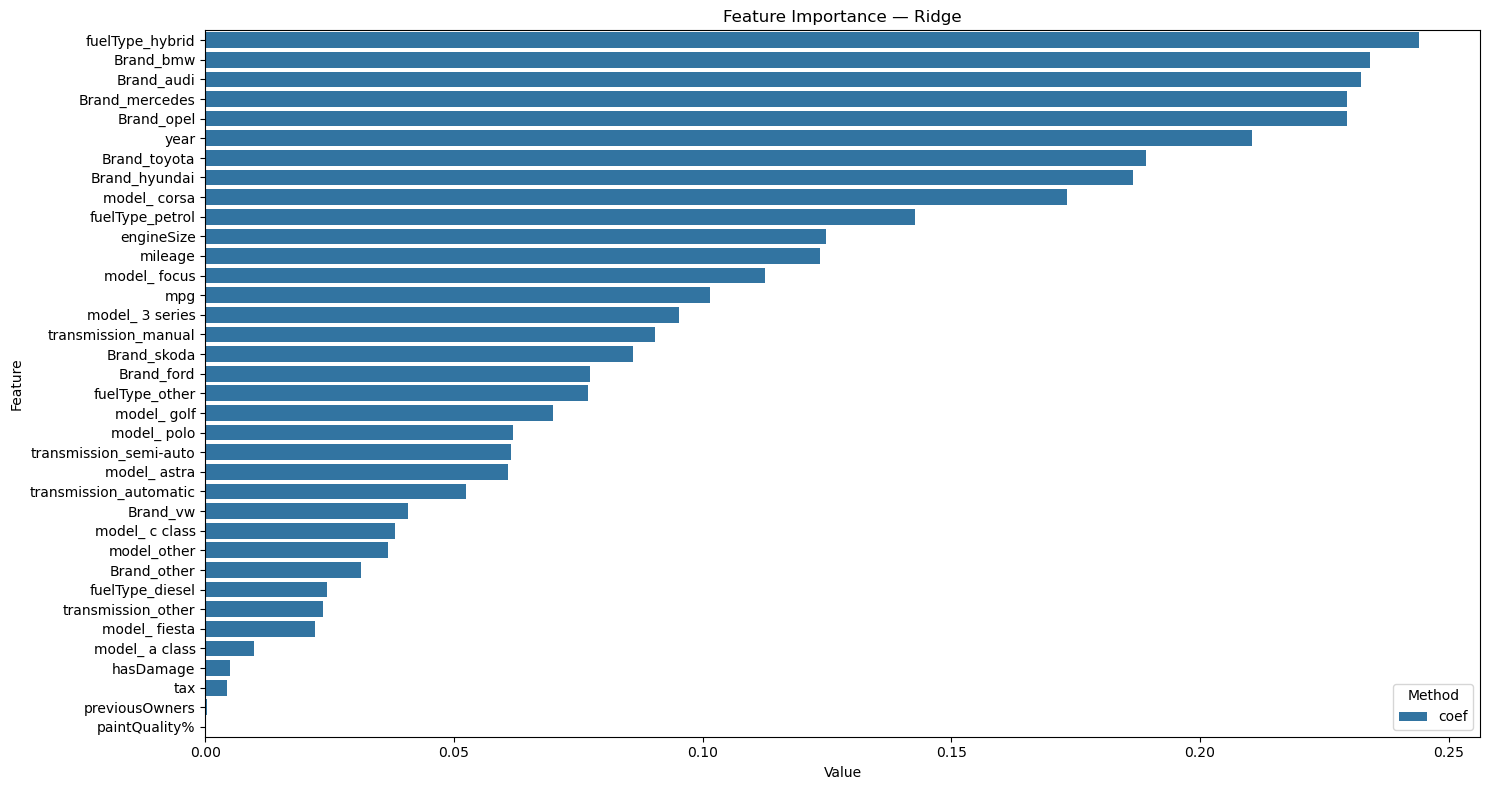

In [14]:
# Plot Feature Importance for Ridge
get_feature_importance(fi_ridge_results['best_estimator'], 
                       preprocess_data(X, cat_cols, num_cols, artifacts=fi_ridge_results['final_artifacts'], fit=False))

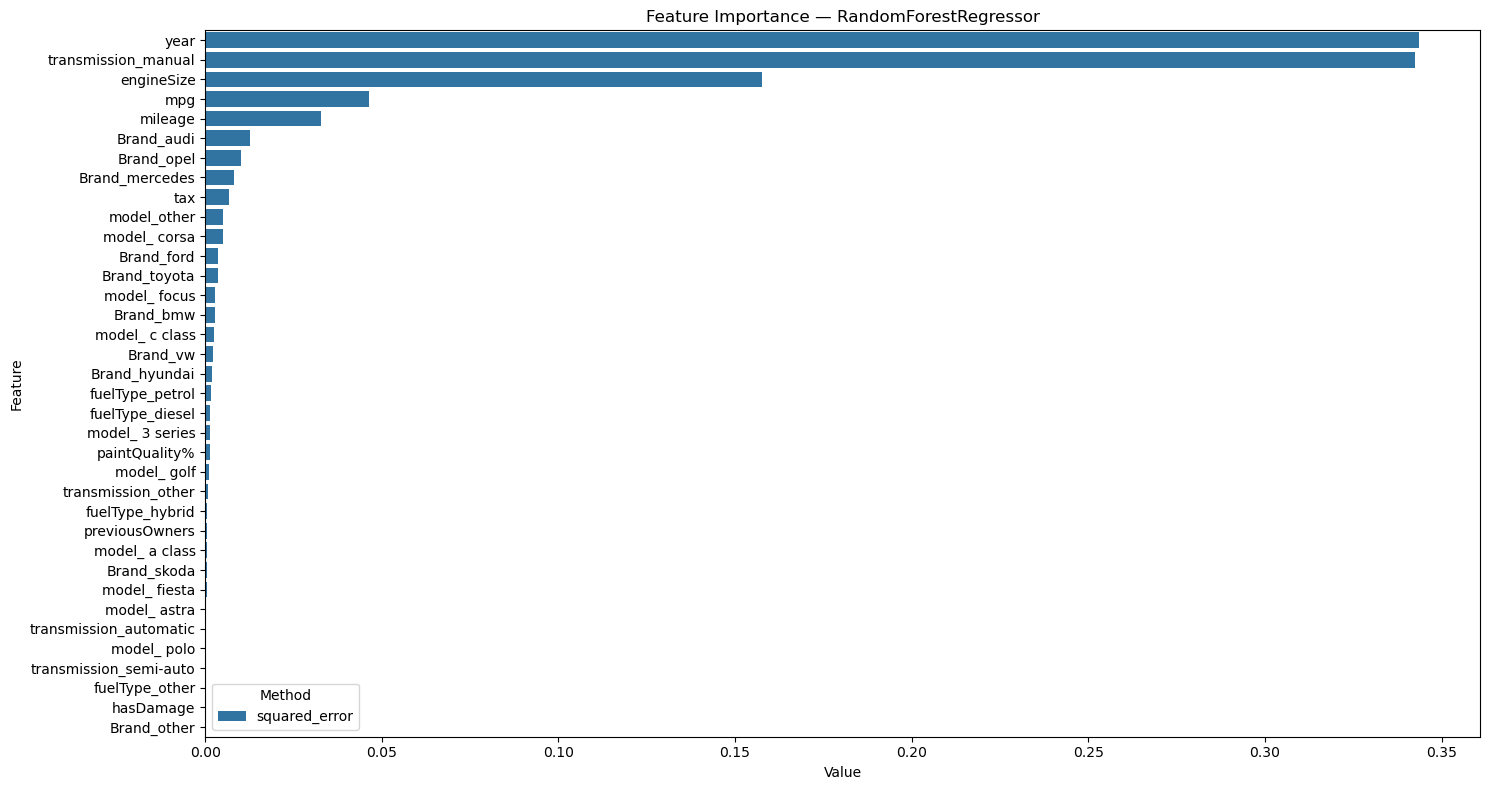

In [15]:
# Plot Feature Importance for Random Forest
get_feature_importance(fi_rf_results['best_estimator'], 
                       preprocess_data(X, cat_cols, num_cols, artifacts=fi_rf_results['final_artifacts'], fit=False))

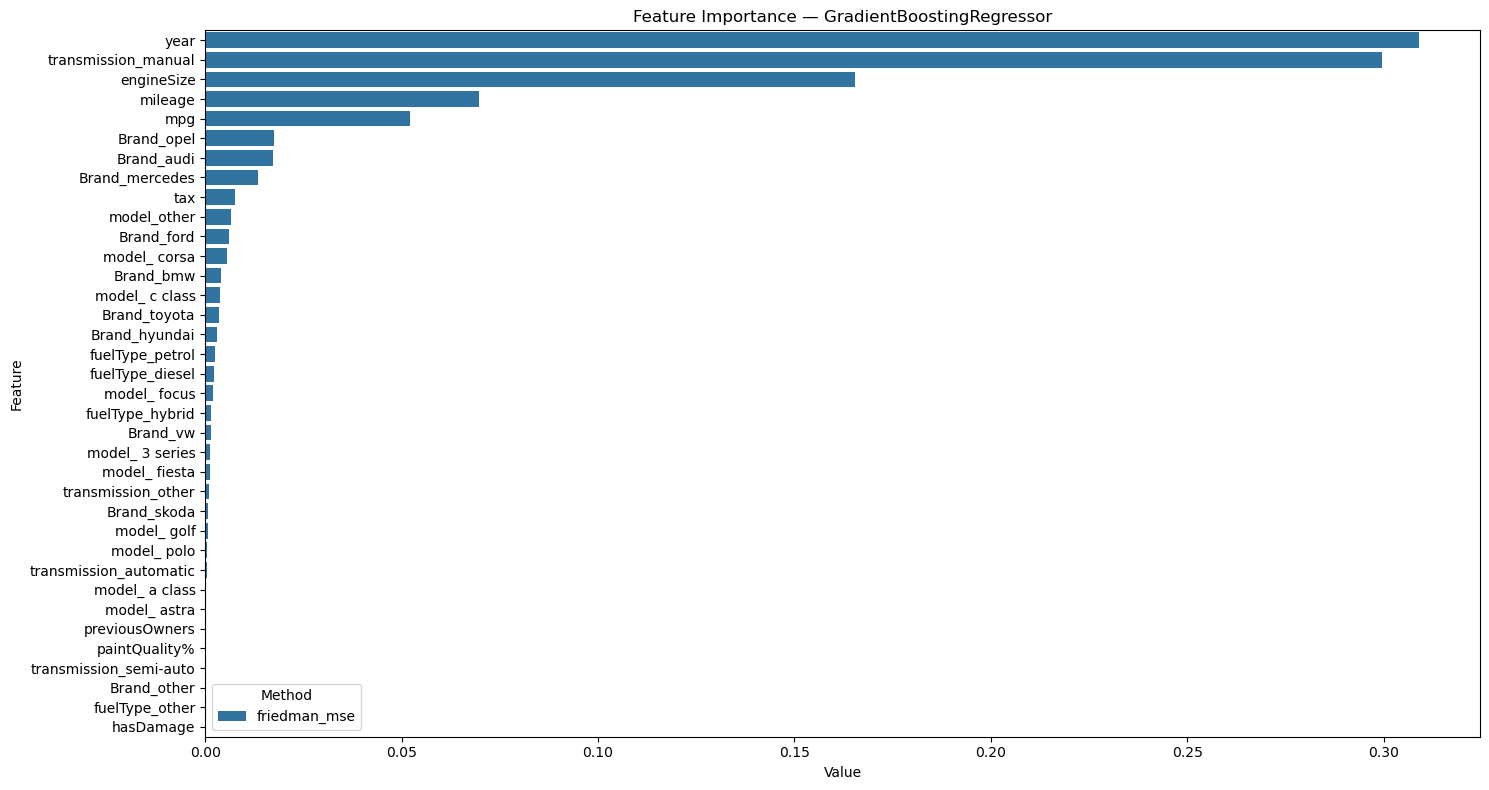

In [16]:
# Plot Feature Importance for Gradient Boosting
get_feature_importance(fi_gb_results['best_estimator'], 
                       preprocess_data(X, cat_cols, num_cols, artifacts=fi_gb_results['final_artifacts'], fit=False))

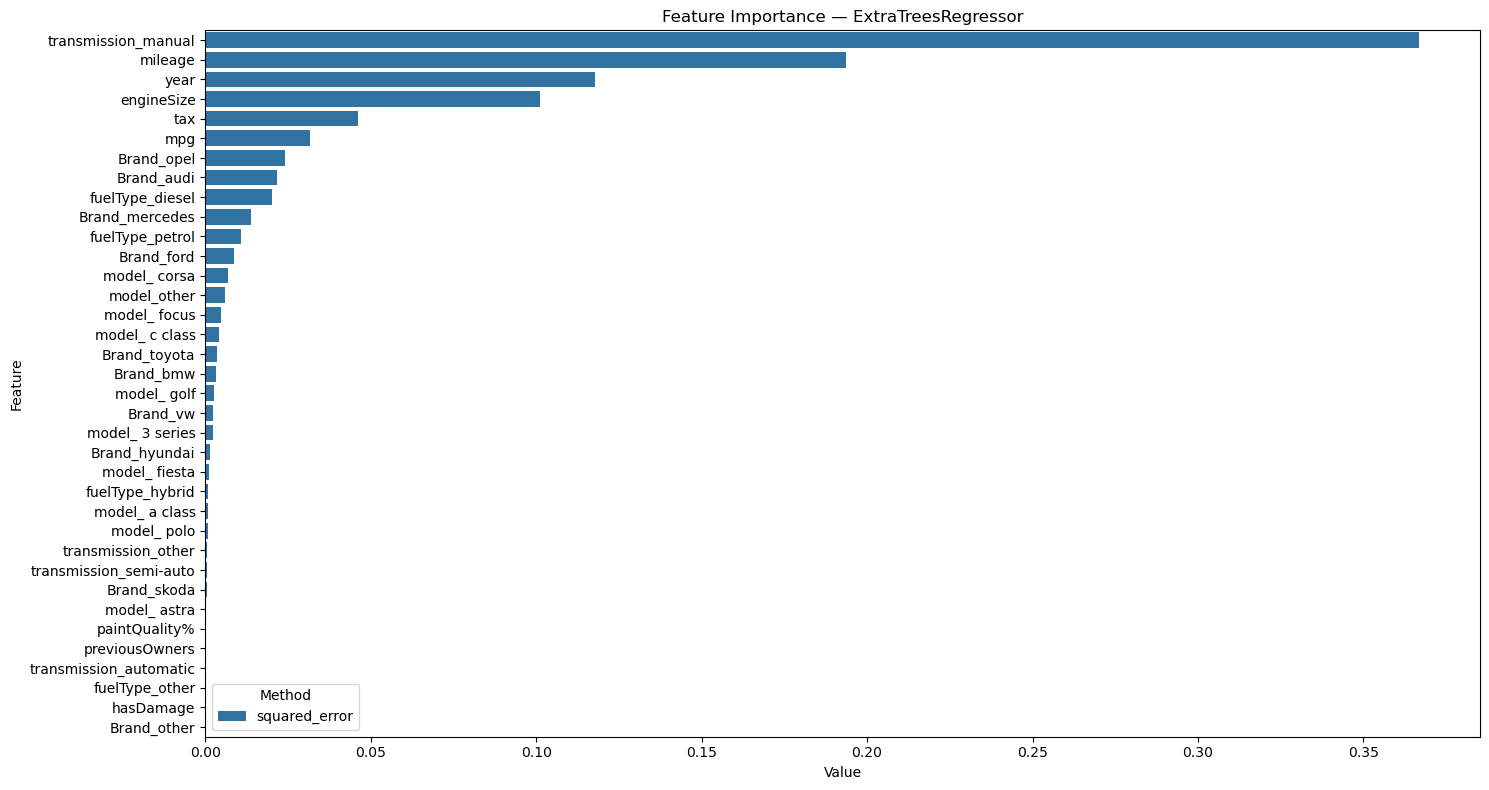

In [17]:
# Plot Feature Importance for Extra Trees
get_feature_importance(fi_et_results['best_estimator'], 
                       preprocess_data(X, cat_cols, num_cols, artifacts=fi_et_results['final_artifacts'], fit=False))

In [ ]:
# Get the list of all processed feature names from one of the artifacts
all_features = list(preprocess_data(X, cat_cols, num_cols, artifacts=fi_ridge_results['final_artifacts'], fit=False).columns)

print("Original Feature Count:", len(all_features))

# Define features to remove based on feature importance analysis
features_to_remove = [
    'hasDamage',
    'paintQuality%',
    'transmission_other'
    'tax',
    'model_other',
    'fuelType_other',
    'Brand_other',
    'transmission_automatic',
    'previousOwners',
    'model_ a class',
    'model_ fiesta'
]

selected_features = [f for f in all_features if f not in features_to_remove]

print(f"\nSelected {len(selected_features)} features.")

Original Feature Count: 36

Selected 3 features.


<a id="experiment-algorithms"></a>
### Experiment Algorithms

Now we'll experiment with different algorithms using cross-validation with hyperparameter tuning.

In [19]:
# Example 1: Ridge Regression with hyperparameter tuning
ridge_config = {
    'model_class': Ridge,
    'param_distributions': {
        'alpha': loguniform(1e-3, 1e2),
        'fit_intercept': [True, False]
    },
    'n_iter': 20
}

ridge_results = cross_validate_with_tuning(X, y, cat_cols, num_cols, ridge_config, k=3, seed=SEED, selected_features=selected_features)

Starting 3-Fold CV with Ridge (20 hyperparam combinations)...

Refitting best model on all available data...
Fitted 60 models in total.
Features Selected: 27

Top 5 Hyperparameter Combinations:
 mean_val_mae  std_val_mae   alpha  fit_intercept
    2562.9557      23.1207 17.1124           True
    2562.9827      23.1583 14.9352           True
    2563.0060      23.1866 13.2540           True
    2563.0090      23.1902 13.0482           True
    2563.0850      23.2728  8.3016           True

Best Model Performance (Across Folds):
Fold   | Train MAE    | Val MAE     
------------------------------------
1      | £2576.53    | £2536.44   
2      | £2545.55    | £2592.78   
3      | £2562.18    | £2559.64   
------------------------------------
Mean CV MAE: £2562.96 ± £23.12
Best Fold MAE: £2536.44



In [20]:
# Example 2: Lasso Regression
lasso_config = {
    'model_class': Lasso,
    'param_distributions': {
        'alpha': loguniform(1e-3, 1e2),
        'fit_intercept': [True, False]
    },
    'n_iter': 20
}

lasso_results = cross_validate_with_tuning(X, y, cat_cols, num_cols, lasso_config, k=3, seed=SEED, selected_features=selected_features)

Starting 3-Fold CV with Lasso (20 hyperparam combinations)...

Refitting best model on all available data...
Fitted 60 models in total.
Features Selected: 27

Top 5 Hyperparameter Combinations:
 mean_val_mae  std_val_mae  alpha  fit_intercept
    2587.5297      19.1419 0.0012           True
    2632.4529      18.7787 0.0027           True
    2638.5026      18.6954 0.0029           True
    3324.3807      26.7132 0.0320           True
    3946.0347      40.9240 0.0746           True

Best Model Performance (Across Folds):
Fold   | Train MAE    | Val MAE     
------------------------------------
1      | £2600.23    | £2562.18   
2      | £2571.37    | £2608.42   
3      | £2586.93    | £2591.99   
------------------------------------
Mean CV MAE: £2587.53 ± £19.14
Best Fold MAE: £2562.18



In [29]:
# Example 3: Random Forest
rf_config = {
    'model_class': RandomForestRegressor,
    'param_distributions': {
        'n_estimators': randint(50, 200),
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': randint(2, 20),
        'min_samples_leaf': randint(1, 10),
        'max_features': ['sqrt', 0.5],
    },
    'n_iter': 10
}

rf_results = cross_validate_with_tuning(X, y, cat_cols, num_cols, rf_config, k=3, seed=SEED, selected_features=selected_features)

Starting 3-Fold CV with RandomForestRegressor (10 hyperparam combinations)...

Refitting best model on all available data...
Fitted 30 models in total.
Features Selected: 3

Top 5 Hyperparameter Combinations:
 mean_val_mae  std_val_mae  n_estimators  max_depth  min_samples_split  min_samples_leaf max_features
    3358.9840      21.0607           185       20.0                  9                 8         sqrt
    3361.2480      22.4500           164       30.0                 12                 9         sqrt
    3361.8974      21.6654           152       20.0                  8                 7          0.5
    3369.9441      22.9107           119       20.0                  7                 6          0.5
    3377.1386      21.7809            70       20.0                  5                 5          0.5

Best Model Performance (Across Folds):
Fold   | Train MAE    | Val MAE     
------------------------------------
1      | £3097.09    | £3342.14   
2      | £3067.95    | £3388.6

In [22]:
# Example 4: Hist Gradient Boosting Regressor
hgb_config = {
    'model_class': HistGradientBoostingRegressor,
    'param_distributions': {
        'learning_rate': loguniform(0.01, 0.3),
        'max_depth': randint(3, 10),
        'max_leaf_nodes': randint(15, 63),
        'l2_regularization': loguniform(1e-3, 10),
        'max_iter': [100, 200]
    },
    'n_iter': 20
}

hgb_results = cross_validate_with_tuning(X, y, cat_cols, num_cols, hgb_config, k=3, seed=SEED, selected_features=selected_features)

Starting 3-Fold CV with HistGradientBoostingRegressor (20 hyperparam combinations)...

Refitting best model on all available data...
Fitted 60 models in total.
Features Selected: 27

Top 5 Hyperparameter Combinations:
 mean_val_mae  std_val_mae  learning_rate  max_depth  max_leaf_nodes  l2_regularization  max_iter
    1596.4113       8.9037         0.2843          8              36             8.6450       200
    1634.5146       4.9587         0.0996          9              52             0.5046       200
    1720.1263      13.1032         0.1644          8              43             1.9608       100
    1747.5642      15.0441         0.2890          6              26             9.0375       100
    1751.8365      11.5839         0.1711          7              35             2.1846       100

Best Model Performance (Across Folds):
Fold   | Train MAE    | Val MAE     
------------------------------------
1      | £1449.68    | £1604.31   
2      | £1425.01    | £1600.95   
3      | £

In [23]:
# Example 5: Gradient Boosting Regressor (Standard)
gb_config = {
    'model_class': GradientBoostingRegressor,
    'param_distributions': {
        'n_estimators': randint(50, 200),
        'learning_rate': loguniform(0.01, 0.2),
        'max_depth': randint(3, 6),
        'min_samples_split': randint(2, 20),
        'min_samples_leaf': randint(1, 10),
        'subsample': [0.8, 0.9, 1.0]
    },
    'n_iter': 10
}

gb_results = cross_validate_with_tuning(X, y, cat_cols, num_cols, gb_config, k=3, seed=SEED, selected_features=selected_features)

Starting 3-Fold CV with GradientBoostingRegressor (10 hyperparam combinations)...

Refitting best model on all available data...
Fitted 30 models in total.
Features Selected: 27

Top 5 Hyperparameter Combinations:
 mean_val_mae  std_val_mae  n_estimators  learning_rate  max_depth  min_samples_split  min_samples_leaf  subsample
    1696.1777       5.0947           181         0.1935          5                 13                 4        1.0
    2004.7594      10.5956           107         0.0757          5                  7                 6        1.0
    2049.5235       8.1687           119         0.1047          4                  7                 6        0.8
    2146.0650      19.1437           152         0.0307          5                  8                 7        1.0
    2194.1217      17.8071           164         0.0246          5                 12                 9        0.9

Best Model Performance (Across Folds):
Fold   | Train MAE    | Val MAE     
-------------------

In [24]:
# Example 6: Extra Trees Regressor
et_config = {
    'model_class': ExtraTreesRegressor,
    'param_distributions': {
        'n_estimators': randint(50, 200),
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': randint(2, 20),
        'min_samples_leaf': randint(1, 10),
        'max_features': ['sqrt', 0.5]
    },
    'n_iter': 15
}

et_results = cross_validate_with_tuning(X, y, cat_cols, num_cols, et_config, k=3, seed=SEED, selected_features=selected_features)

Starting 3-Fold CV with ExtraTreesRegressor (15 hyperparam combinations)...

Refitting best model on all available data...
Fitted 45 models in total.
Features Selected: 27

Top 5 Hyperparameter Combinations:
 mean_val_mae  std_val_mae  n_estimators  max_depth  min_samples_split  min_samples_leaf max_features
    1624.6303      18.2140           189       30.0                 18                 1          0.5
    1807.9818      19.6145           135       30.0                  6                 6          0.5
    1817.1046      26.2639           161       30.0                 17                 6          0.5
    1831.3640      17.9299            70       20.0                  5                 5          0.5
    1855.0095      17.4076           119       20.0                  7                 6          0.5

Best Model Performance (Across Folds):
Fold   | Train MAE    | Val MAE     
------------------------------------
1      | £1304.47    | £1605.49   
2      | £1302.73    | £1649.13

In [25]:
# Example 7: MLP Regressor (Neural Network)
mlp_config = {
    'model_class': MLPRegressor,
    'param_distributions': {
        'hidden_layer_sizes': [(32,), (64,), (100,), (32, 16), (64, 32), (100, 50)],
        'activation': ['relu', 'tanh'],
        'solver': 'adam',
        'alpha': loguniform(1e-5, 1e-1),
        'learning_rate_init': loguniform(1e-4, 1e-2),
        'max_iter': 500,
        'early_stopping': True
    },
    'n_iter': 10
}

mlp_results = cross_validate_with_tuning(X, y, cat_cols, num_cols, mlp_config, k=3, seed=SEED, selected_features=selected_features)

Starting 3-Fold CV with MLPRegressor (10 hyperparam combinations)...

Refitting best model on all available data...
Fitted 30 models in total.
Features Selected: 27

Top 5 Hyperparameter Combinations:
 mean_val_mae  std_val_mae hidden_layer_sizes activation solver  alpha  learning_rate_init  max_iter  early_stopping
    1907.1795      23.8474           (64, 32)       tanh   adam 0.0002              0.0004       500            True
    1931.7187      38.1781          (100, 50)       tanh   adam 0.0050              0.0022       500            True
    1945.5198      28.1807           (32, 16)       tanh   adam 0.0010              0.0010       500            True
    1971.2603      23.0475             (100,)       relu   adam 0.0137              0.0037       500            True
    1983.6422       1.7773           (64, 32)       tanh   adam 0.0000              0.0002       500            True

Best Model Performance (Across Folds):
Fold   | Train MAE    | Val MAE     
--------------------

### Final Model Selection

I will select the best algorithm with the best hyperparameters and train the model with it. While doing it I want to use all available data.

In [30]:
# Compare all models to find the best one
results = {
    'Ridge': ridge_results,
    'Lasso': lasso_results,
    'Random Forest': rf_results,
    'Hist Gradient Boosting': hgb_results,
    'Gradient Boosting': gb_results,
    'Extra Trees': et_results,
    'MLP': mlp_results
}

# Select the best model based on the lowest mean CV score (MAE)
best_model_name = min(results, key=lambda k: results[k]['mean_cv_score'])
best_result = results[best_model_name]

print(f"Best Model Selected: {best_model_name}")
print(f"Best CV MAE: £{best_result['mean_cv_score']:.2f} ± £{best_result['std_cv_score']:.2f}")
print(f"Best Parameters: {best_result['best_params']}\n")

# The function now returns the model already fitted on ALL available data
# and the corresponding preprocessing artifacts
best_model = best_result['best_estimator']
final_artifacts = best_result['final_artifacts']

print(f"Final model ({best_model_name}) is ready and fitted on all data.")

# Visualize Feature Importance (if applicable)
try:
    # We need the processed feature names for the plot
    X_all_processed = preprocess_data(X, cat_cols, num_cols, artifacts=final_artifacts, fit=False)
    
    # Filter selected features if they were used during training
    if 'selected_features' in final_artifacts:
        X_all_processed = X_all_processed[final_artifacts['selected_features']]
        
    get_feature_importance(best_model, X_all_processed, model_class=type(best_model))
except Exception as e:
    print(f"Could not plot feature importance: {e}")

Best Model Selected: Hist Gradient Boosting
Best CV MAE: £1596.41 ± £8.90
Best Parameters: {'learning_rate': 0.28429596849984995, 'max_depth': 8, 'max_leaf_nodes': 36, 'l2_regularization': 8.645047864945965, 'max_iter': 200}

Final model (Hist Gradient Boosting) is ready and fitted on all data.
Could not plot feature importance: Model HistGradientBoostingRegressor not supported or has no extractable importance.


<a id="predictions"></a>
# Predictions

In [27]:
# Load and preprocess test data
test_df = pd.read_csv('data/test.csv').set_index('carID')

# Use the artifacts from the final fit on all data
test_processed = preprocess_test_data(test_df, final_artifacts)

# Make predictions
test_predictions = np.expm1(best_model.predict(test_processed))

# Save predictions
predictions_df = pd.DataFrame({'price': test_predictions}, index=test_df.index)
predictions_df.to_csv('data/test_predictions.csv')

print(f"Predictions saved for {len(test_predictions)} test samples")
print(f"Predicted price range: £{test_predictions.min():.2f} - £{test_predictions.max():.2f}")

Predictions saved for 32567 test samples
Predicted price range: £1145.49 - £106801.32
